# Preparation

## Modules

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from arch import arch_model
from pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 10, 6
from pmdarima.arima import auto_arima

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error

from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Data

In [2]:
stock_data = pd.read_csv('VIC_SSI.csv')

In [3]:
for i, r in stock_data.iterrows():
    stock_data['t'][i]=datetime.fromtimestamp(stock_data['t'][i]).date()

In [4]:
stock_data.set_index('t',inplace=True)

In [5]:
del stock_data['Unnamed: 0']
del stock_data['s']

In [6]:
stock_data

,c,o,h,l,v
t,,,,,
2008-01-02,6.13,6.09,6.13,6.05,156160
2008-01-03,6.01,6.05,6.09,6.01,111990
2008-01-04,5.93,5.97,5.97,5.93,66670
2008-01-07,5.85,5.89,5.93,5.78,117490
2008-01-08,5.89,5.85,6.01,5.85,109010
...,...,...,...,...,...
2023-07-05,51.00,51.40,51.60,50.90,2479200
2023-07-06,50.40,51.00,51.40,50.40,2599600
2023-07-07,50.10,50.50,50.60,50.00,2941600


# EDA

## Closing price

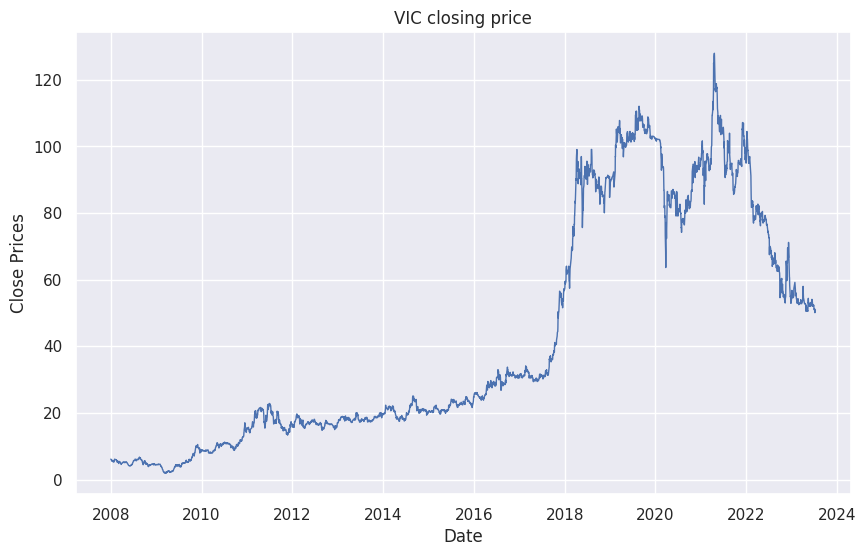

In [7]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['c'],linewidth=1)
plt.title('VIC closing price')
plt.show()

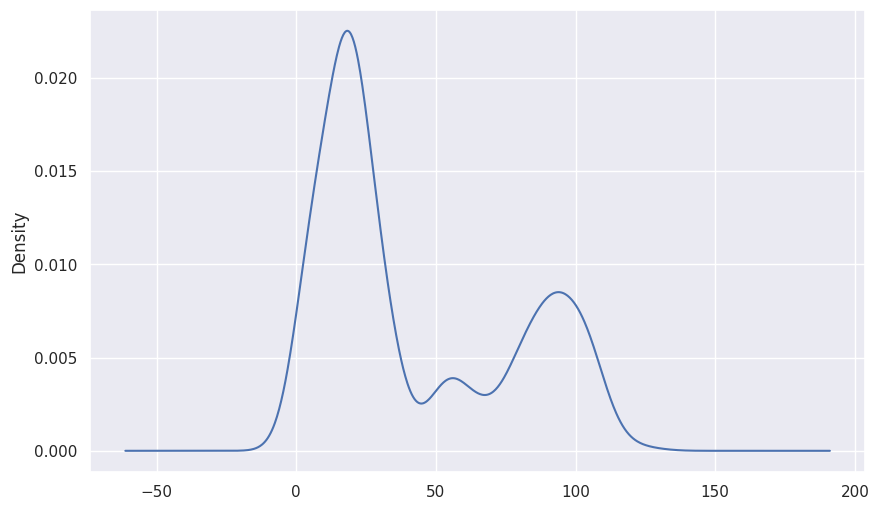

In [8]:
stock_data['c'].plot(kind='kde')
plt.show()

#### ADF (Augmented Dickey-Fuller) Test

- The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

+ Null Hypothesis: The series has a unit root (value of a =1)

+ Alternate Hypothesis: The series has no unit root.

- If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

- If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

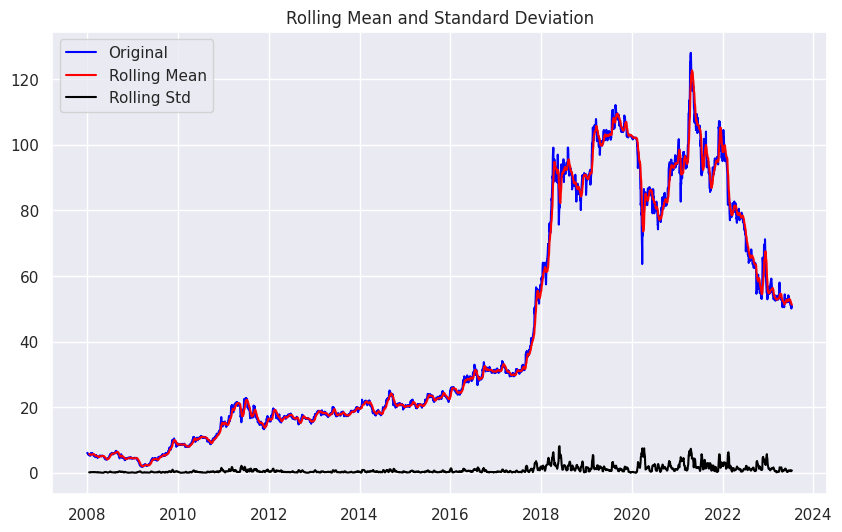

Results of dickey fuller test
Test Statistics                  -1.148546
p-value                           0.695329
No. of lags used                 19.000000
Number of observations used    3834.000000
critical value (1%)              -3.432057
critical value (5%)              -2.862294
critical value (10%)             -2.567171
dtype: float64


In [9]:
# Test for staionarity
rolling_days = 12

def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(rolling_days).mean()
    rolstd = timeseries.rolling(rolling_days).std()
    
    # Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    
    # Output for dft will give us without defining what the values are, hence I manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(stock_data['c'])

- Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

- We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

- In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.

<Figure size 1000x600 with 0 Axes>

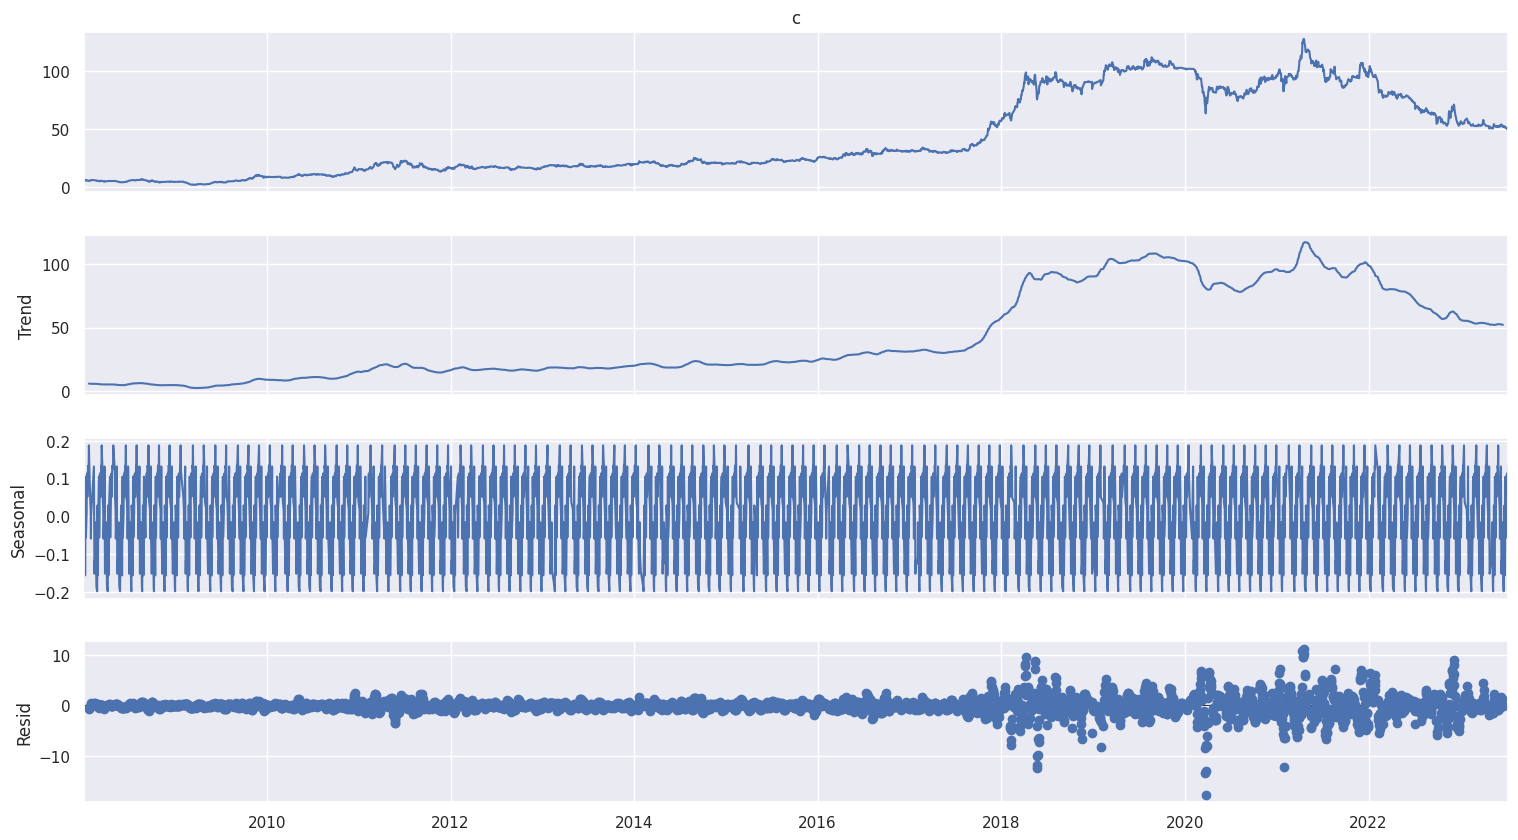

In [10]:
# To separate the trend and the seasonality from a time series, we can decompose the series using the following code.
result = seasonal_decompose(stock_data['c'], model='additive', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
plt.show()

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


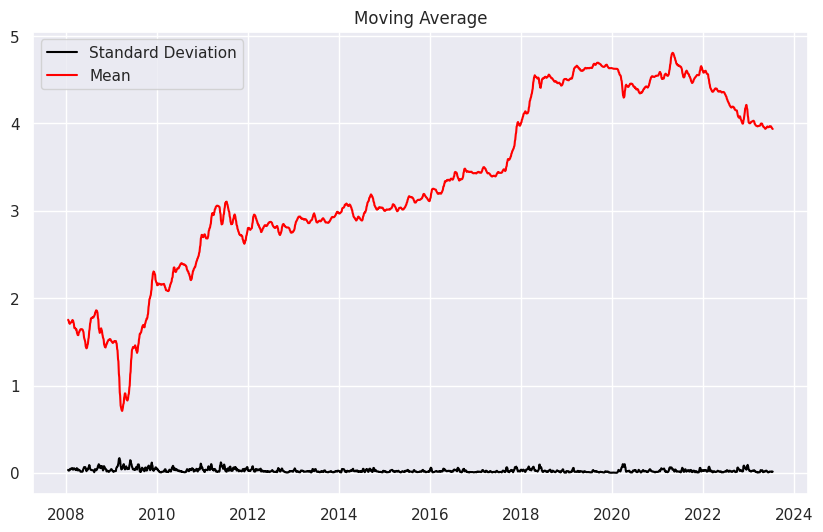

Results of dickey fuller test
Test Statistics                  -1.419627
p-value                           0.572831
No. of lags used                  1.000000
Number of observations used    3852.000000
critical value (1%)              -3.432049
critical value (5%)              -2.862291
critical value (10%)             -2.567170
dtype: float64


In [11]:
# If not stationary then eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(stock_data['c'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

print("Results of dickey fuller test")
adft = adfuller(df_log,autolag='AIC')
# Output for dft will give us without defining what the values are, hence I manually write what values does it explains using a for loop
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

In [12]:
returns = np.log(stock_data['c']/stock_data['c'].shift(1))
returns.dropna(inplace=True)
print("Results of dickey fuller test")
adft = adfuller(returns,autolag='AIC')
# Output for dft will give us without defining what the values are, hence I manually write what values does it explains using a for loop
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output)

Results of dickey fuller test
Test Statistics                 -54.382150
p-value                           0.000000
No. of lags used                  0.000000
Number of observations used    3852.000000
critical value (1%)              -3.432049
critical value (5%)              -2.862291
critical value (10%)             -2.567170
dtype: float64


# Modelling

In [13]:
# Split data into train and training set
train_percent = 0.85
train_data, test_data = df_log[:int(len(df_log)*train_percent)], df_log[int(len(df_log)*train_percent):]

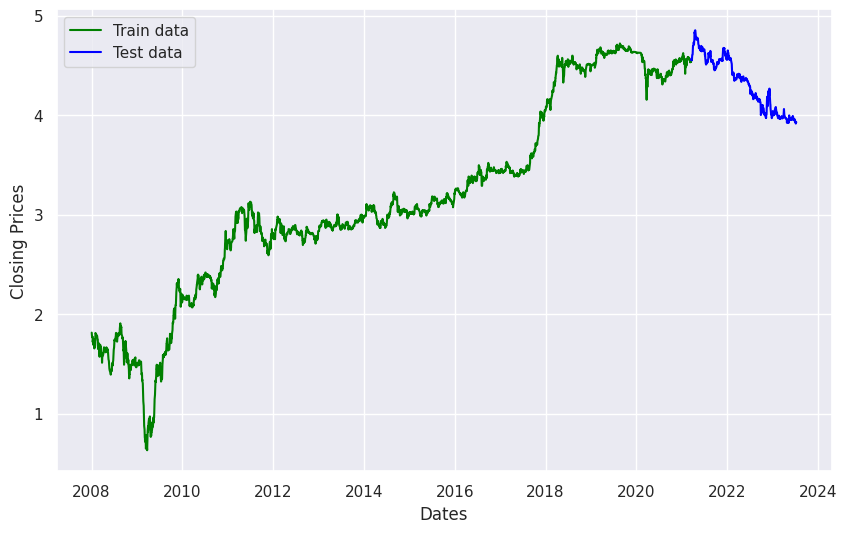

In [14]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()

## Arima

Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16005.943, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16065.523, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16063.417, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16002.815, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16063.657, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16063.644, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16061.691, Time=0.80 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16063.645, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.073 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3275
Model:               SARIMAX(1, 1, 0)   Log Likelihood                8035.761
Date:                Sun, 13 Aug 2023   AIC                         -16065.523
Time:               

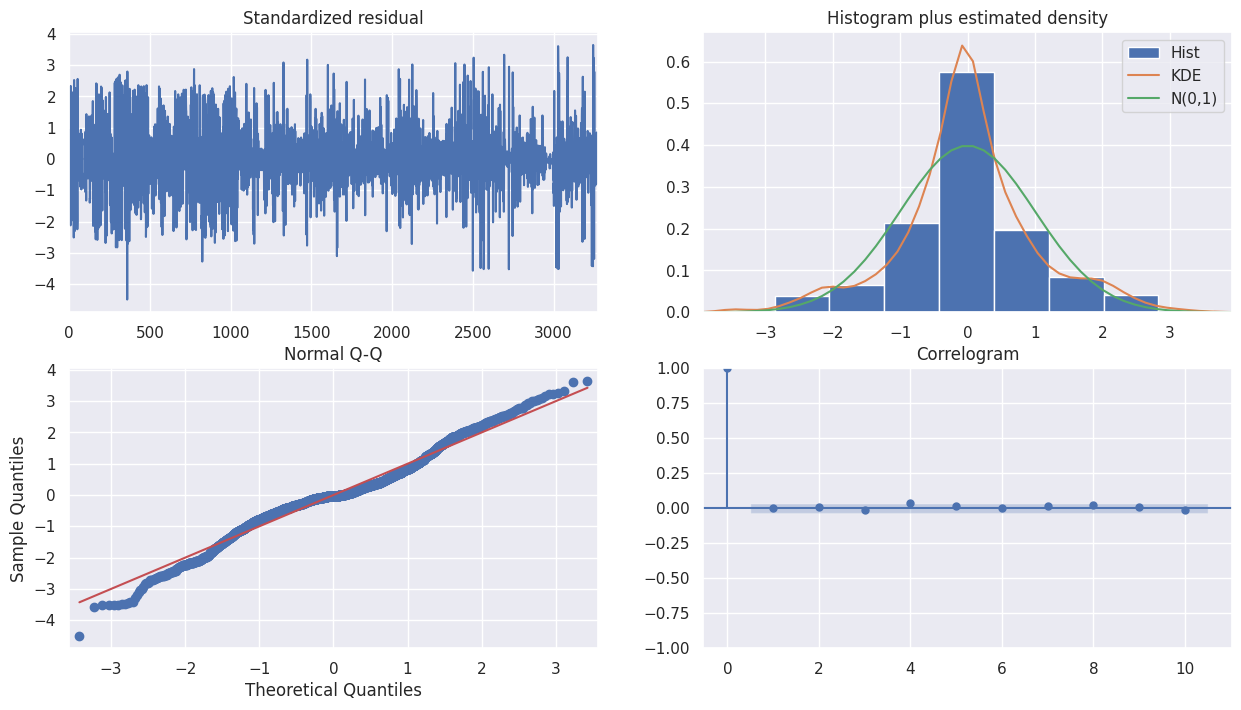

In [16]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
parameter = model_autoARIMA.get_params().get('order')
print(f'Optimal order for is: {parameter} \n')
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

- Standardized residual: cho thấy sự thay đổi của sai số chuẩn hóa (standardized residuals) theo thời gian. Nếu sai số chuẩn hóa duy trì trong khoảng giá trị thấp gần 0 và không có xu hướng tăng hoặc giảm đột ngột, mô hình có thể được coi là tốt.
- Density plot: Biểu đồ mật độ cho thấy dữ liệu có phân phối chuẩn với giá trị trung bình bằng không.
- Normal Q-Q: cho phép đánh giá phân phối của các sai số (residuals) của mô hình. Nếu sai số có phân phối gần với phân phối chuẩn, biểu đồ sẽ trông như một đường chéo. Nếu có độ lệch khỏi đường chéo, điều này có thể chỉ ra rằng sai số không tuân theo phân phối chuẩn.
- Correlogram: giúp kiểm tra xem có sự tương quan còn tồn tại trong các sai số hay không. Nếu tất cả các giá trị nằm trong khoảng giới hạn cho phép (tức là nằm trong khoảng sai số không đáng kể), mô hình có thể được coi là có hiệu suất tốt.

In [17]:
warnings.simplefilter('ignore')
arm_history = [x for x in train_data]
arm_predictions = list()

# Walk-forward validation
for t in range(len(test_data)):
    arm_model = sm.tsa.arima.ARIMA(arm_history, order=parameter)
    arm_model_fit = arm_model.fit()
    output = arm_model_fit.forecast()
    yhat = output[0]
    arm_predictions.append(yhat)
    obs = test_data[t]
    arm_history.append(obs)

In [18]:
arm_predictions = pd.Series(arm_predictions, index=test_data.index)

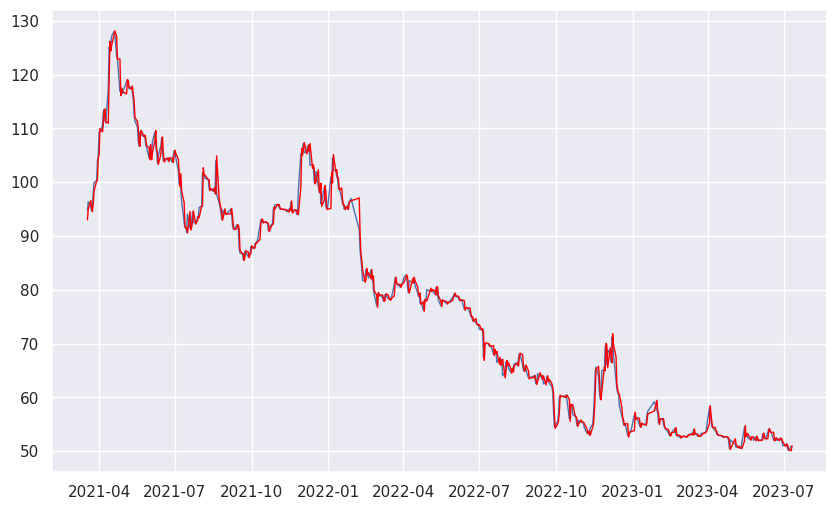

In [20]:
plt.plot(np.exp(test_data),linewidth=1)
plt.plot(np.exp(arm_predictions), color='red',linewidth=1)
plt.show()

In [11]:
# report performance
mse = mean_squared_error(np.exp(test_data), np.exp(arm_predictions))
print('MSE: '+str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(arm_predictions))
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(arm_predictions)))
print('RMSE: '+str(rmse))

MSE: 1.6417857333151613
MAE: 0.9117019203178167
RMSE: 1.5072444172446489


# GARCH

In [22]:
train_data, test_data = returns.values[:int(len(returns) * train_percent)], returns.values[int(len(returns) * train_percent):]

In [24]:
# Log returns
returns.fillna(0, inplace=True)

In [25]:
garch_model = arch_model(train_data, p=2, q=1,vol='Garch')
garch_model_fit = garch_model.fit()
garch_model_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 14264459715.502398
Iteration:      2,   Func. Count:     21,   Neg. LLF: 15914.09099716412
Iteration:      3,   Func. Count:     33,   Neg. LLF: 6378432.958421946
Iteration:      4,   Func. Count:     45,   Neg. LLF: -8384.948419672473
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8384.94842183455
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8384.95
Distribution:                  Normal   AIC:                          -16759.9
Method:            Maximum Likelihood   BIC:                          -16729.4
                                        No. Observations:                 3275
Date:                Sun, Aug 13 2023   Df Residuals:                     3274
Time:                        02:21:58   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.6166e-04  2.778e-04      1.662  9.655e-02 [-8.283e-05,1.006e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.4032e-05  4.355e-06     10.111  4.938e-24 [3.550e-05,5.257e-05]
alpha[1]       0.1000  1.920e-02      5.208  1.906e-07   [6.237e-02,  0.138]
alpha[2]       0.1000  2.566e-02      3.897  9.733e-05   [4.971e-02,  0.150]
beta[1]        0.7000  2.711e-02     25.825 4.651e-147     [  0.647,  0.753]
============================================================================

Covariance estimator: robust
"""

In [26]:
#Fit the GARCH model
garch_predictions = []
test_size = len(test_data)

for i in range(test_size):
    train = returns.values[:-(test_size-i)]
    garch_model = arch_model(train, vol='Garch', p=2, q=1)
    garch_model_fit = garch_model.fit(disp='off')
    pred = garch_model_fit.forecast(horizon=1)
    garch_predictions.append(pred.mean.values[-1,:][0])

In [27]:
true = (np.exp(test_data)*stock_data['c'].shift(1)[-len(test_data):]).values
pred = (np.exp(garch_predictions))*(stock_data['c'].shift(1).values[-len(test_data):])

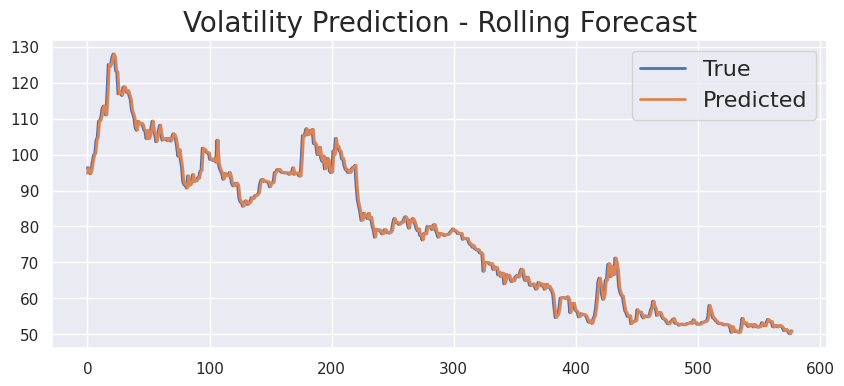

In [28]:
plt.figure(figsize=(10,4))
plt.plot(true,linewidth=2)
plt.plot(pred,linewidth=2)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True', 'Predicted'], fontsize=16)

In [12]:
# report performance
mse = mean_squared_error(true,pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(true,pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(true,pred))
print('RMSE: '+str(rmse))

MSE: 1.0818865912769036
MAE: 0.8413574244950583
RMSE: 1.5105914706752794


# EGARCH

In [32]:
egarch_predictions = []
test_size = len(test_data)
for i in range(test_size):
    train = returns[:-(test_size-i)]
    egarch_model = arch_model(train, p=2, q=1, vol='EGARCH')
    egarch_model_fit = egarch_model.fit(disp='off')
    pred = egarch_model_fit.forecast(horizon=1)
    egarch_predictions.append(pred.mean.values[-1,:][0])

In [33]:
true = (np.exp(test_data)*stock_data['c'].shift(1)[-len(test_data):]).values
pred = (np.exp(egarch_predictions))*(stock_data['c'].shift(1).values[-len(test_data):])

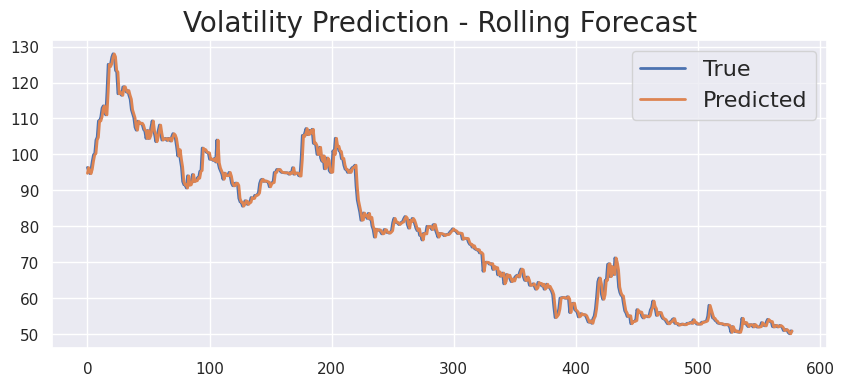

In [34]:
plt.figure(figsize=(10,4))
plt.plot(true,linewidth=2)
plt.plot(pred,linewidth=2)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True', 'Predicted'], fontsize=16)

In [13]:
# report performance
mse = mean_squared_error(true,pred[-len(test_data):])
print('MSE: '+str(mse))
mae = mean_absolute_error(true,pred[-len(test_data):])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(true,pred[-len(test_data):]))
print('RMSE: '+str(rmse))

MSE: 1.07361081322552
MAE: 0.8262664874002945
RMSE: 1.507849731646201


# EGARCH with sentiment

In [15]:
sent_stock=pd.read_csv('VIC_sentiment_model.csv')

In [17]:
sent_stock.head()

,Unnamed: 0,t,c,o,h,l,v,s,point
0,0,02/01/2008,6.13,6.09,6.13,6.05,156160,ok,68.0
1,1,03/01/2008,6.01,6.05,6.09,6.01,111990,ok,68.0
2,2,04/01/2008,5.93,5.97,5.97,5.93,66670,ok,68.0
3,3,07/01/2008,5.85,5.89,5.93,5.78,117490,ok,68.0
4,4,08/01/2008,5.89,5.85,6.01,5.85,109010,ok,68.0


In [37]:
# returns = returns['c']
egarch_model = arch_model(returns, p=2, q=1, x=sent_stock['point'],vol='EGARCH')
egarch_model_fit = egarch_model.fit()
egarch_model_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 2.6169857967809104e+16
Iteration:      2,   Func. Count:     21,   Neg. LLF: 51790019307.82295
Iteration:      3,   Func. Count:     31,   Neg. LLF: 2524164138292.2637
Iteration:      4,   Func. Count:     40,   Neg. LLF: 8765228048.445417
Iteration:      5,   Func. Count:     51,   Neg. LLF: -9770.106808396595
Iteration:      6,   Func. Count:     58,   Neg. LLF: 96190650.63374555
Iteration:      7,   Func. Count:     66,   Neg. LLF: -9903.943218954326
Iteration:      8,   Func. Count:     73,   Neg. LLF: -9922.1559526744
Iteration:      9,   Func. Count:     80,   Neg. LLF: -9926.798023265674
Iteration:     10,   Func. Count:     86,   Neg. LLF: -9926.84217191982
Iteration:     11,   Func. Count:     92,   Neg. LLF: -9926.844458780772
Iteration:     12,   Func. Count:     98,   Neg. LLF: -9926.845231514493
Iteration:     13,   Func. Count:    104,   Neg. LLF: -9926.84525743887
Iteration:     14,   Func. Count:    110,   Neg. LLF: 

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Dep. Variable:                      c   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                9926.85
Distribution:                  Normal   AIC:                          -19843.7
Method:            Maximum Likelihood   BIC:                          -19812.4
                                        No. Observations:                 3853
Date:                Sun, Aug 13 2023   Df Residuals:                     3852
Time:                        02:22:19   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -3.0678e-04  3.200e-04     -0.959      0.338 [-9.339e-04,3.204e-04]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega         -0.5162      0.142     -3.644  2.689e-04 [ -0.794, -0.239]
alpha[1]       0.4485  3.589e-02     12.495  7.968e-36 [  0.378,  0.519]
alpha[2]      -0.2052  4.720e-02     -4.348  1.373e-05 [ -0.298, -0.113]
beta[1]        0.9325  1.822e-02     51.172      0.000 [  0.897,  0.968]
========================================================================

Covariance estimator: robust
"""

In [4]:
# compute volatility using Pandas rolling and std methods, the trading days is set to 252 days
sent_returns = np.log(sent_stock['c']/sent_stock['c'].shift(1))
sent_returns.fillna(0, inplace=True)

In [5]:
sent_stock['log_return']=sent_returns

In [6]:
del sent_stock['Unnamed: 0']

In [7]:
sent_stock.set_index('t',inplace=True)

In [8]:
sent_stock['point']/=100
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sent_stock['point'] = scaler.fit_transform(sent_stock[['point']]).flatten()

In [9]:
sent_stock.head()

,c,o,h,l,v,s,point,log_return
t,,,,,,,,
02/01/2008,6.13,6.09,6.13,6.05,156160,ok,-0.038987,0.000000
03/01/2008,6.01,6.05,6.09,6.01,111990,ok,-0.038987,-0.019770
04/01/2008,5.93,5.97,5.97,5.93,66670,ok,-0.038987,-0.013401
07/01/2008,5.85,5.89,5.93,5.78,117490,ok,-0.038987,-0.013583
08/01/2008,5.89,5.85,6.01,5.85,109010,ok,-0.038987,0.006814


In [59]:
test_size = len(sent_stock)-int(len(sent_stock)*train_percent)

In [60]:
train_sent = sent_stock[:-test_size]
test_sent = sent_stock[-test_size:]

In [61]:
egarch_model = arch_model(returns, p=2, q=1,x=train_sent['point'],vol='EGARCH')
egarch_model_fit = egarch_model.fit()
egarch_model_fit.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 2.6169857967809104e+16
Iteration:      2,   Func. Count:     21,   Neg. LLF: 51790019307.82295
Iteration:      3,   Func. Count:     31,   Neg. LLF: 2524164138292.2637
Iteration:      4,   Func. Count:     40,   Neg. LLF: 8765228048.445417
Iteration:      5,   Func. Count:     51,   Neg. LLF: -9770.106808396595
Iteration:      6,   Func. Count:     58,   Neg. LLF: 96190650.63374555
Iteration:      7,   Func. Count:     66,   Neg. LLF: -9903.943218954326
Iteration:      8,   Func. Count:     73,   Neg. LLF: -9922.1559526744
Iteration:      9,   Func. Count:     80,   Neg. LLF: -9926.798023265674
Iteration:     10,   Func. Count:     86,   Neg. LLF: -9926.84217191982
Iteration:     11,   Func. Count:     92,   Neg. LLF: -9926.844458780772
Iteration:     12,   Func. Count:     98,   Neg. LLF: -9926.845231514493
Iteration:     13,   Func. Count:    104,   Neg. LLF: -9926.84525743887
Iteration:     14,   Func. Count:    110,   Neg. LLF: 

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Dep. Variable:                      c   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                9926.85
Distribution:                  Normal   AIC:                          -19843.7
Method:            Maximum Likelihood   BIC:                          -19812.4
                                        No. Observations:                 3853
Date:                Sun, Aug 13 2023   Df Residuals:                     3852
Time:                        02:24:30   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -3.0678e-04  3.200e-04     -0.959      0.338 [-9.339e-04,3.204e-04]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega         -0.5162      0.142     -3.644  2.689e-04 [ -0.794, -0.239]
alpha[1]       0.4485  3.589e-02     12.495  7.968e-36 [  0.378,  0.519]
alpha[2]      -0.2052  4.720e-02     -4.348  1.373e-05 [ -0.298, -0.113]
beta[1]        0.9325  1.822e-02     51.172      0.000 [  0.897,  0.968]
========================================================================

Covariance estimator: robust
"""

In [62]:
egarch_predictions = []
test_size = len(test_sent)
for i in range(test_size):
    train = train_sent['log_return'].values[:-(test_size-i)]    
    egarch_model = arch_model(train,x=train_sent['point'].values[:-(test_size-i)], p=2, q=1,vol='EGARCH',mean='LS')
    egarch_model_fit = egarch_model.fit(disp='off')
    egarch_prediction_model = egarch_model_fit.forecast(horizon=1, x=np.array(train_sent['point'].values[test_size-i].reshape(1,1)))
    egarch_predictions.append(egarch_prediction_model.mean.values[-1,:][0])

In [63]:
egarch_predictions = pd.Series(egarch_predictions,index = test_sent.index)

In [64]:
true = (np.exp(sent_stock['log_return'].abs())*sent_stock['c'].shift(1))[-len(test_sent):]
pred = np.exp(egarch_predictions)*(sent_stock['c'].shift(1)).values[-len(test_sent):]

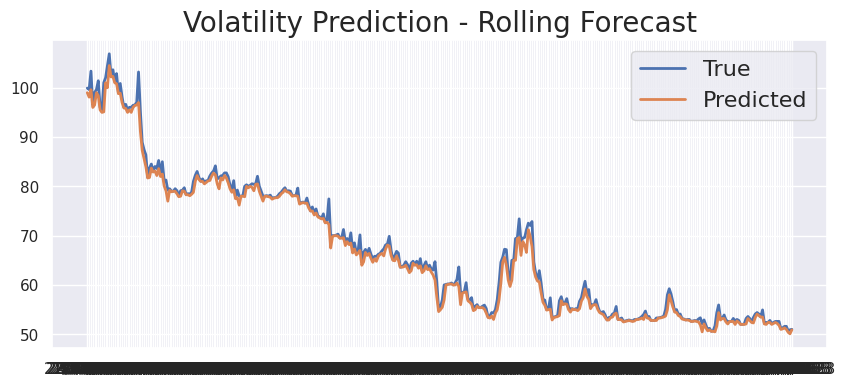

In [65]:
plt.figure(figsize=(10,4))
plt.plot(true,linewidth=2)
plt.plot(pred,linewidth=2)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True', 'Predicted'], fontsize=16)
plt.show()

In [14]:
# report performance
mse = mean_squared_error(true,pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(true,pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(true,pred))
print('RMSE: '+str(rmse))

MSE: 0.95012463854335
MAE: 0.7665933926207978
RMSE: 1.3209891989923064
